# Sheet 4: Solution

In [1]:
options(jupyter.plot_mimetypes = 'image/png',repr.plot.width=4,repr.plot.height=4) # this is just to render graphics as png and not as svg, and to adjust the default size

## Exercise 1: Variance of beta

To compute the covariance of the components of 
the vector $\hat\beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T Y$
we assume $Y = X^T \beta + \epsilon$ with $\epsilon \sim \mathcal{N}(0,\sigma^2)$, as 
specified on the sheet. This assumes that the whole randomness of $Y$
comes from $\epsilon$, given knowledge of $X$. Therefore

\begin{align}
\text{Var}_{Y|X}(\hat\beta) 
& = E_{Y|X} \left[(\hat\beta - E_{Y|X}(\hat\beta) (\hat\beta - E_{Y|X}(\hat\beta))^T\right] \\
& = E_{Y|X} \left[ \big((\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T (X^T\beta + \epsilon) - (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T X^T\beta )\big) \big(...\big)^T \right] \\
& = E_{Y|X} \left[ (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \epsilon  \epsilon \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1}  \right] \\
& = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T E_{Y|X} \left[ \epsilon  \epsilon \right] \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} \\
& = (\mathbf{X}^T \mathbf{X})^{-1} \sigma^2.
\end{align}


## Exercise 2: Ridge regression

In [2]:
pcancer <- read.table("prostate.data", header=TRUE)
write.csv(pcancer,file="prostate.csv",row.names=FALSE,col.names=FALSE)

Warning message in write.csv(pcancer, file = "prostate.csv", row.names = FALSE, :
“attempt to set 'col.names' ignored”

In [3]:
# There's a training sub-dataset that we will focus on. Later, we will try to predict
# the values of the remaining observations.
p <- 8
Xtrain <- pcancer[which(pcancer$train),0:p+1]
head(Xtrain)

lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
-0.5798185,2.769459,50,-1.386294,0,-1.386294,6,0,-0.4307829
-0.9942523,3.319626,58,-1.386294,0,-1.386294,6,0,-0.1625189
-0.5108256,2.691243,74,-1.386294,0,-1.386294,7,20,-0.1625189
-1.2039728,3.282789,58,-1.386294,0,-1.386294,6,0,-0.1625189
0.7514161,3.432373,62,-1.386294,0,-1.386294,6,0,0.3715636
-1.0498221,3.228826,50,-1.386294,0,-1.386294,6,0,0.7654678


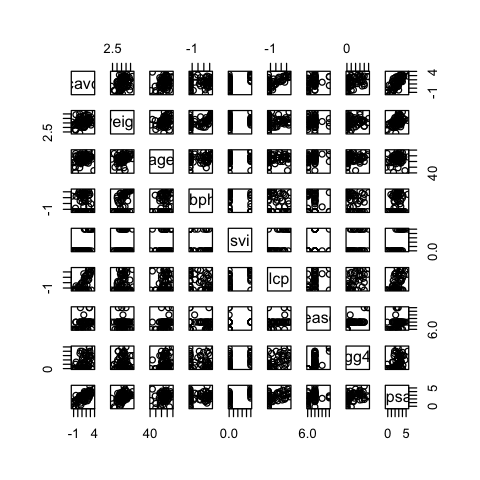

In [4]:
# Analysis of prostate-specific antigen and clinical measures
# among men who were about to have their prostates removed
# - lcavol : log(cancer volume)
# - lweight : log(prostate weight)
# - age : age
# - lbph : log(benign prostatic hyperplasia)
# - svi : seminal vesicle invasion
# - lcp : log(capsular penetration)
# - gleason : Gleason score
# - pgg45 : percent of Gleason scores 4 or 5

# - lpsa : log(prostate-specific antigen)

plot(Xtrain)

In [5]:
# We see that there are many strong correlations between features
# and lpsa. Therefore we need to fit the effects jointly to
# disentangle the relationships between the features and lpsa.
round(cor(Xtrain),3)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000,0.300,0.286,0.063,0.593,0.692,0.426,0.483,0.733
lweight,0.300,1.000,0.317,0.437,0.181,0.157,0.024,0.074,0.485
age,0.286,0.317,1.000,0.287,0.129,0.173,0.366,0.276,0.228
lbph,0.063,0.437,0.287,1.000,-0.139,-0.089,0.033,-0.030,0.263
svi,0.593,0.181,0.129,-0.139,1.000,0.671,0.307,0.481,0.557
lcp,0.692,0.157,0.173,-0.089,0.671,1.000,0.476,0.663,0.489
gleason,0.426,0.024,0.366,0.033,0.307,0.476,1.000,0.757,0.342
pgg45,0.483,0.074,0.276,-0.030,0.481,0.663,0.757,1.000,0.448
lpsa,0.733,0.485,0.228,0.263,0.557,0.489,0.342,0.448,1.000


In [6]:
# scale data sets to have zero mean and unit variance
Xtrain <- pcancer[which(pcancer$train),0:p+1]
Xtest <- pcancer[-which(pcancer$train),0:p+1]

X = Xtrain
dim(Xtrain)
lpsa = X$lpsa 
X$lpsa = NULL
X = scale(X, TRUE, TRUE)
means = attr(X,"scaled:center")
stds = attr(X,"scaled:scale")
print(means)
print(stds)

Xf = data.frame(X)
Xf$lpsa = lpsa
Xtrain <- Xf
head(Xtrain)
sd(Xtrain$lpsa)

DCVTest  = Xtest
lpsaTest = DCVTest$lpsa # in physical units (not mean adjusted)
DCVTest$lpsa = NULL 
DCVTest  = t( apply( DCVTest, 1, '-', means ) ) 
DCVTest  = t( apply( DCVTest, 1, '/', stds ) ) 
DCVTestb = cbind( DCVTest, lpsaTest ) # append back on the response
DCVTestf = data.frame( DCVTestb ) # a data frame containing all scaled variables of interest
names(DCVTestf)[p+1] = "lpsa" # fix the name of the response
Xtest <- DCVTestf

head(Xtest)

[1] 67  9

     lcavol     lweight         age        lbph         svi         lcp 
 1.31349155  3.62610769 64.74626866  0.07143991  0.22388060 -0.21420301 
    gleason       pgg45 
 6.73134328 26.26865672 
    lcavol    lweight        age       lbph        svi        lcp    gleason 
 1.2425904  0.4766008  7.5022083  1.4636549  0.4199890  1.4007352  0.7088636 
     pgg45 
29.3017644 


lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
-1.5236800,-1.7974136,-1.9655904,-0.9959549,-0.533063,-0.8367687,-1.0317123,-0.8964872,-0.4307829
-1.8572040,-0.6430575,-0.8992377,-0.9959549,-0.533063,-0.8367687,-1.0317123,-0.8964872,-0.1625189
-1.4681565,-1.9615258,1.2334677,-0.9959549,-0.533063,-0.8367687,0.3789964,-0.2139344,-0.1625189
-2.0259809,-0.7203486,-0.8992377,-0.9959549,-0.533063,-0.8367687,-1.0317123,-0.8964872,-0.1625189
-0.4523417,-0.4064926,-0.3660614,-0.9959549,-0.533063,-0.8367687,-1.0317123,-0.8964872,0.3715636
-1.9019250,-0.8335733,-1.9655904,-0.9959549,-0.533063,-0.8367687,-1.0317123,-0.8964872,0.7654678


[1] 1.207812

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
7,-0.46381132,-0.32016249,-0.0994732,0.3714986,-0.533063,-0.8367687,-1.0317123,-0.8964872,0.7654678
9,-1.68198659,-0.18170069,-2.3654727,-0.9959549,-0.533063,-0.8367687,-1.0317123,-0.8964872,1.0473190
10,-0.87747984,-0.80059395,-0.2327673,-0.9959549,-0.533063,-0.8367687,-1.0317123,-0.8964872,1.0473190
15,-0.08652952,-0.38625345,-1.0325318,-0.9959549,-0.533063,-0.1546187,0.3789964,-0.7258490,1.3987169
22,0.60015537,-0.26240975,-0.6326495,0.9587800,-0.533063,1.1153258,0.3789964,-0.2139344,1.6582281
25,-0.74701138,0.08663921,0.5669972,1.0439262,-0.533063,-0.8367687,-1.0317123,-0.8964872,1.7316555


In [7]:
# We fit a linear model to the output variable lpsa
model.ls <- lm(lpsa ~ ., data=Xtrain)
summary(model.ls)
# The Z-score for \hat\beta_j is the t value for testing whether we can 
# exclude the parameter from the model.
# We are confident that we need lcavol, lweight, lpbh and svi in the model,
# all of which are significant at the 5% level.
# We are not sure about whether we could exclude age, lcp, gleason and pgg45 from the model.


Call:
lm(formula = lpsa ~ ., data = Xtrain)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.64870 -0.34147 -0.05424  0.44941  1.48675 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.45235    0.08702  28.182  < 2e-16 ***
lcavol       0.71641    0.13350   5.366 1.47e-06 ***
lweight      0.29264    0.10638   2.751  0.00792 ** 
age         -0.14255    0.10212  -1.396  0.16806    
lbph         0.21201    0.10312   2.056  0.04431 *  
svi          0.30962    0.12539   2.469  0.01651 *  
lcp         -0.28901    0.15480  -1.867  0.06697 .  
gleason     -0.02091    0.14258  -0.147  0.88389    
pgg45        0.27735    0.15959   1.738  0.08755 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7123 on 58 degrees of freedom
Multiple R-squared:  0.6944,	Adjusted R-squared:  0.6522 
F-statistic: 16.47 on 8 and 58 DF,  p-value: 2.042e-12


In [8]:
# Let's now fit a ridge regression for different values of the penalizer lambda
library(MASS)
lam = seq(0,10000,len=5000)
print(lam[5000])
model.ridge <- lm.ridge(lpsa ~ ., data=Xtrain, lambda = lam)
summary(model.ridge)

[1] 10000


       Length Class  Mode   
coef   40000  -none- numeric
scales     8  -none- numeric
Inter      1  -none- numeric
lambda  5000  -none- numeric
ym         1  -none- numeric
xm         8  -none- numeric
GCV     5000  -none- numeric
kHKB       1  -none- numeric
kLW        1  -none- numeric

[1] 5000    9

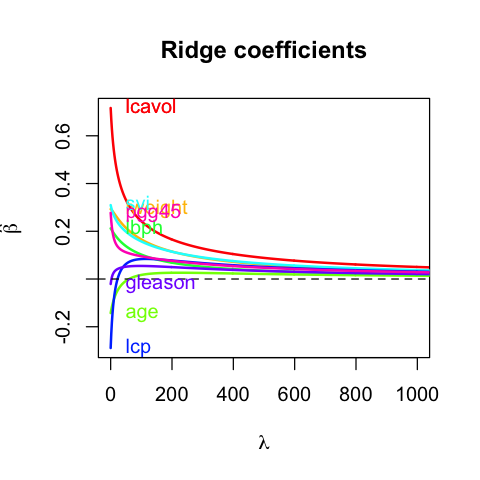

In [9]:
# Plot the coefficients and see how they vary as a function of lambda
colors <- rainbow(8)
dim(coef(model.ridge))
matplot(lam, coef(model.ridge)[,-1], xlim=c(0,1000), type="l",xlab=expression(lambda), 
    ylab=expression(hat(beta)), col=colors, lty=1, lwd=2, main="Ridge coefficients")
abline(h=0, lty=2)
text(rep(10, 9), coef(model.ridge)[1,-1], colnames(Xtrain)[-9], pos=4, col=colors)

In [10]:
# compute the degrees of freedom for each value of lambda
D = Xtrain[,0:8] # get the predictor data
D = as.matrix(D) # is already scaled, but if we don't repeat it here we get an error below 
lpsa = Xtrain[,9]
for( ii in 1:length(lam) ){
  lamii = lam[ii]
  # compute the ridge-regression beta hat estimates:
  #
  M = ginv( t(D) %*% D + lamii*diag(p) ) %*% t(D)
  # this is just an alternative way of estimating the coefficients of the Ridge regression, Eq. (20) in the lecture note 
  betaHat = M %*% as.matrix(lpsa) 
  # compute the degrees of freedom for this values of lambda:
  #
  dof = sum( diag( D %*% M ) ) 
  # each column is a different value of the complexity parameter ...
  if( ii==1 ){
    betaRes = betaHat
    dofRes  = dof 
  }else{
    betaRes = cbind( betaRes, betaHat )
    dofRes  = cbind( dofRes, dof ) 
  }
}

print(dim(betaRes))

[1]    8 5000


0.7164070,0.2926424,-0.14254963,0.2120076,0.3096195,-0.28900562,-0.020913520,0.2773460
0.6668520,0.2906245,-0.12835378,0.2078765,0.2984837,-0.22732704,-0.003370247,0.2412992
0.6267946,0.2877996,-0.11590122,0.2037188,0.2889815,-0.18003795,0.008378840,0.2158781
0.5934680,0.2845189,-0.10489693,0.1996110,0.2807225,-0.14267747,0.016665318,0.1971711
0.5651295,0.2809823,-0.09510522,0.1955950,0.2734292,-0.11247688,0.022762441,0.1829382
0.5406153,0.2773100,-0.08633832,0.1916932,0.2669010,-0.08761777,0.027410497,0.1718131


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0.0000,0.7164070,0.2926424,-0.14254963,0.2120076,0.3096195,-0.28900562,-0.020913520,0.2773460
2.0004,0.6675131,0.2906618,-0.12855203,0.2079386,0.2986367,-0.22812775,-0.003581718,0.2417463
4.0008,0.6278822,0.2878918,-0.11625066,0.2038424,0.2892455,-0.18128878,0.008086518,0.2165254
6.0012,0.5948432,0.2846724,-0.10536217,0.1997932,0.2810699,-0.14418079,0.016348144,0.1979003
8.0016,0.5667044,0.2811982,-0.09565937,0.1958317,0.2738414,-0.11411522,0.022444734,0.1836900
10.0020,0.5423322,0.2775869,-0.08696070,0.1919802,0.2673653,-0.08931867,0.027102442,0.1725575


[1]    1 5000


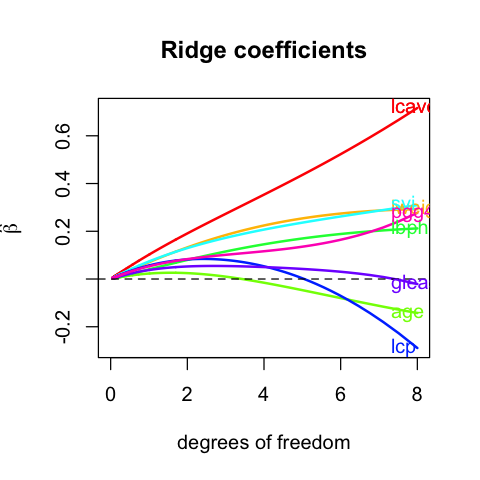

In [11]:
# the following two lines are just to check the calculation
head(t(betaRes))
head(coef(model.ridge)[,-1])
print(dim(dofRes))
matplot(as.numeric(dofRes[1,]), t(betaRes), xlim=c(0,8), type="l",xlab="degrees of freedom", 
    ylab=expression(hat(beta)), col=colors, lty=1, lwd=2, main="Ridge coefficients")
abline(h=0, lty=2)
text(rep(7, 9), coef(model.ridge)[1,-1], colnames(Xtrain)[-9], pos=4, col=colors)

[1] 5000

[1] 4.0008

lcavol      lweight          age         lbph          svi 
 2.452345085  0.627882203  0.287891765 -0.116250655  0.203842427  0.289245522 
         lcp      gleason        pgg45 
-0.181288784  0.008086518  0.216525446

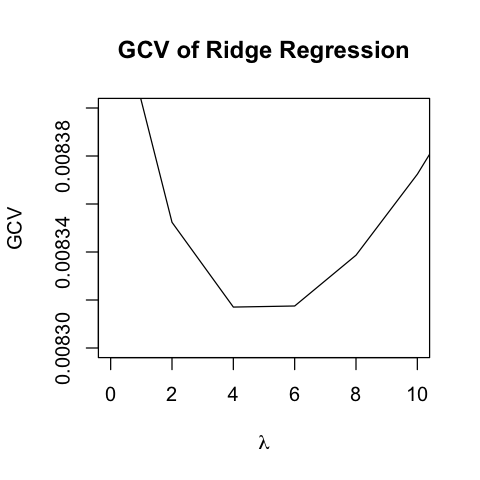

In [15]:
# Use cross-validation to obtain the optimal value of lambda
plot(lam, model.ridge$GCV, main="GCV of Ridge Regression", type="l", xlim=c(0,10), ylim=c(0.0083,0.0084),
    xlab=expression(lambda), ylab="GCV")
length(lam)
# The optimal lambda is given by
lambda.ridge <- lam[which.min(model.ridge$GCV)]
lambda.ridge
beta.ridge <- coef(model.ridge)[which.min(model.ridge$GCV),]
beta.ridge

In [13]:
beta.ridge[2:9]
y.new <- Xtest$lpsa
pss.ls <- sum((y.new - predict(model.ls, Xtest[,1:8]))^2)
pss.ridge <- sum((y.new - beta.ridge[1] - as.matrix(Xtest[,1:8])%*%beta.ridge[2:9])^2)

lcavol      lweight          age         lbph          svi          lcp 
 0.627882203  0.287891765 -0.116250655  0.203842427  0.289245522 -0.181288784 
     gleason        pgg45 
 0.008086518  0.216525446

In [14]:
pss.ls
pss.ridge

[1] 15.63822

[1] 14.91189

## Exercise 3: Modified ridge regression

Insert zeros $\overline{x}_j-\overline{x}_j$ in the original Ridge regression:
\begin{align}
\beta
& = \text{argmin}_{\beta} \sum_{i=1}^N [y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j ]^2
+ \lambda \sum_{i=1}^N \beta_j^2 \\
& = \text{argmin}_{\beta} \sum_{i=1}^N [y_i - \beta_0 - \sum_{j=1}^p \overline{x}_j \beta_j  - \sum_{j=1}^p (x_{ij} - \overline{x}_j) \beta_j ]^2
+ \lambda \sum_{i=1}^N \beta_j^2
\end{align}

From this one sees that the redefined *centered* values can be defined as
\begin{align}
\beta_0^c & = \beta_0 - \sum_{j=1}^p \overline{x}_j \beta_j \\
\beta_j^c & = \beta_j, ~\forall j > 0.
\end{align}

Therefore, only the intercept of the data is changed but the slope is kept constant.